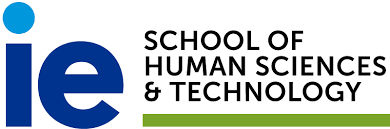

# <font color=#003091> Assignment: Navigating traffic </font>
### <font color=#0098df> Master in Computer Science & Business Technology</font>
#### <font color=#a6a6a6> Year: 2023</font>  
**David Kremer**


This notebook provides a guideline for the Assignment, and shows the steps to build a RL algorithm that navigates through traffic.

# The RL Toolbox

In the previous sessions we saw how to interact with environments through the Gym interface, how to collect data with the Agent class given a policy, and how to train a policy with the QPolicy class. 

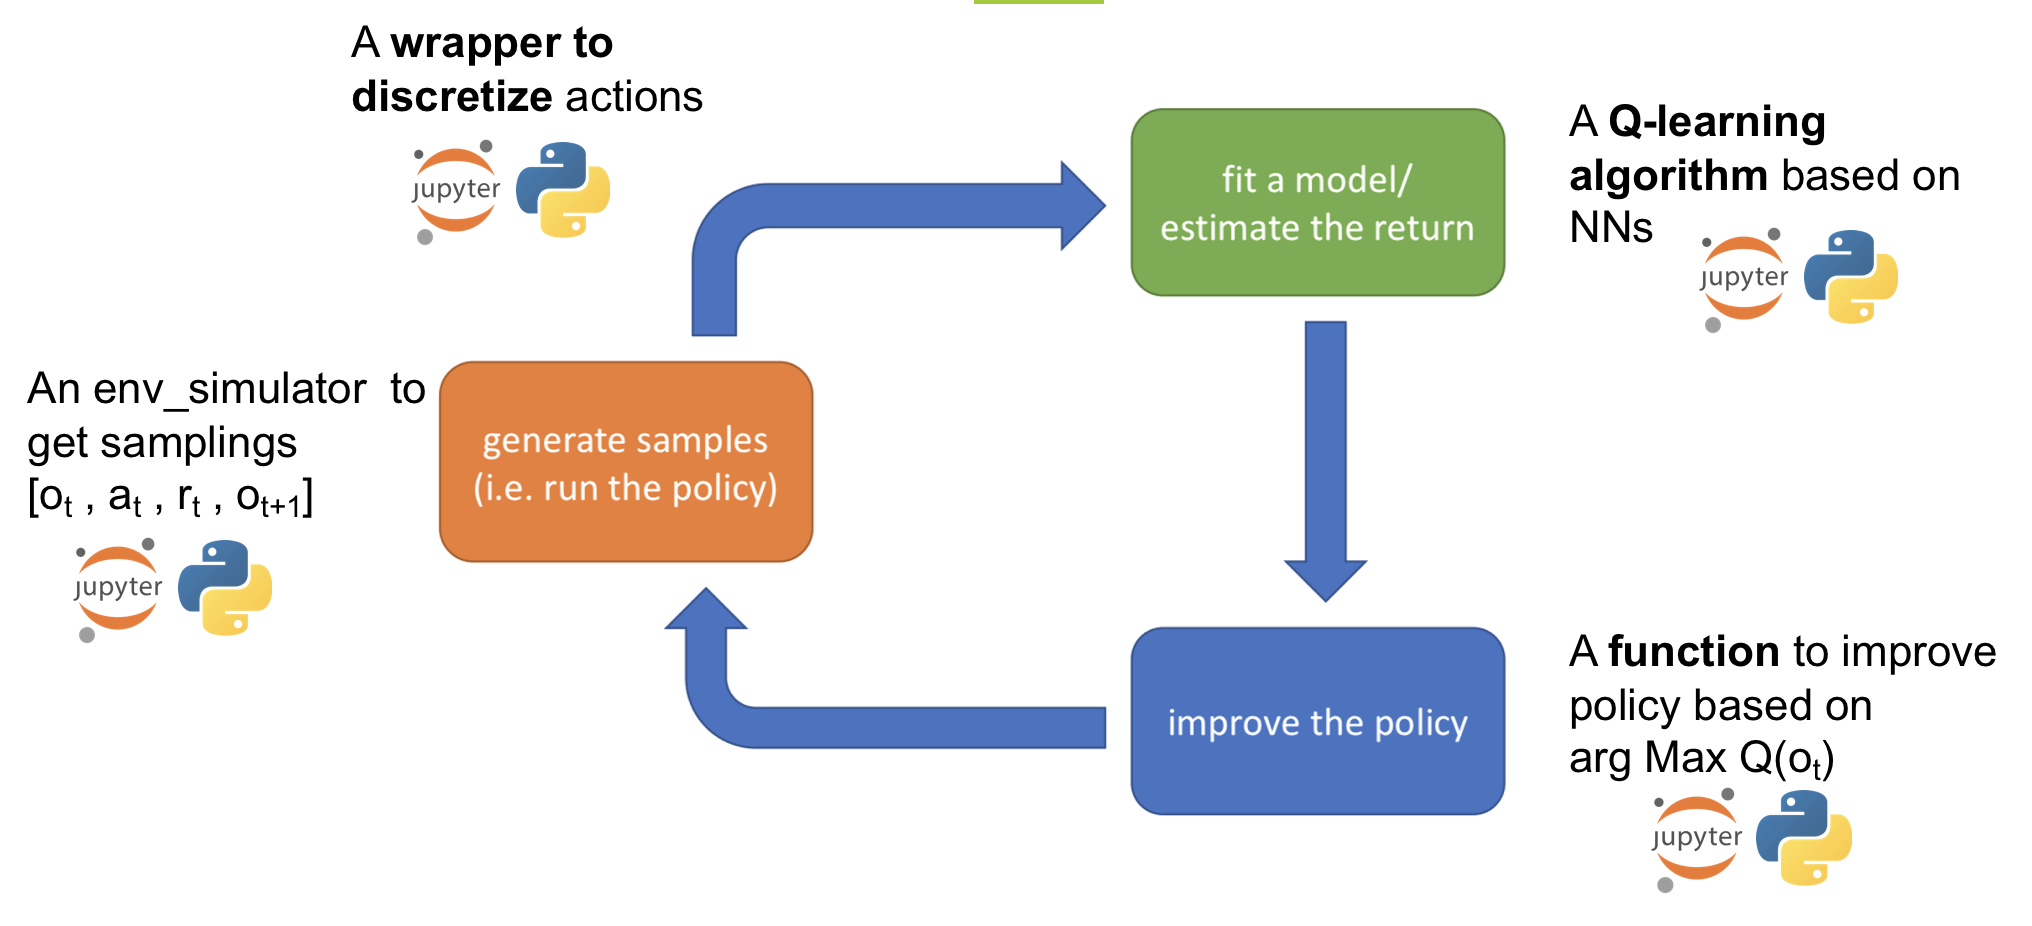

The Memory, Agent and QPolicy classes can be loaded by simply importing them as:

In [1]:
from rl.agent import Memory, Agent
from rl.dqn import QPolicy

They can be used in the same way as in the previous sessions. 

# The environment

For this assignment the environment is a traffic simulator that we can import in the following way:

In [2]:
import gym
from rl.traffic import TrafficEnv
from rl.traffic import Car

To create an environment variable that we can interact with in the same way as with the Gym environments, we just have to use the class TrafficEnv:

In [3]:
env = TrafficEnv(nlanes=4, ncars=5, images=True)

The TrafficEnv accepts 3 arguments for creating the environment:
 - nlanes: number of lanes in the road
 - ncars: number of cars in the road
 - images(true/false): if true, the observations are images of the road, if false the observations are the state of environment
 
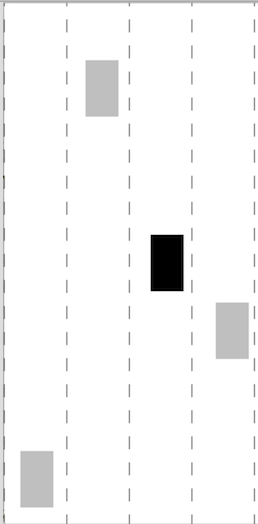
 
In the environment, the agent can control a car that is able to accelerate, break and change lanes to navigate through traffic.

# The Task

The task is to build and train a RL algorithm, using the provided toolbox, that interacts with the Traffic environment and achives the following goals:
 - Not crashing
 - Covering the most distance possible in a given time
 - Driving "efficiently" (that is, change lanes the least possible)

The following sections outline the different steps to take to achive that.

## 1 - Understanding the Env

Before starting the training and sampling, it is important to understand the environment. In particular, it is important to understand the action space and the observation space.

In the case of our particular environment, we have two choices of observations: images from the road, or the road's state (that is, positions and velocities of the cars). 

In this stage you should:
 - Understand and describe the shape and type of the action space
 - Understand and describe the shape and type of the observation space for both the images and the state cases.
 - Decide which of the two observation spaces you will choose, and justify your decision.

In [4]:
# Print the shape of observation space and action space
print("Observation space shape:", env.observation_space.shape)

print("Action space discrete shape:", env.action_space[0])
print("Action space box shape:", env.action_space[1])

Observation space shape: (25, 50)
Action space discrete shape: Discrete(3)
Action space box shape: Box(0.0, 1.0, (2,), float64)


Action space is divided into a tuple composed of 2 elements:
- The first element corresponds to three integer values: 0 for moving left, 1 for straight and 2 to the right
- The second value corresponds to a list of two values, the first is the acceleration, and the second braking.

For the observation space:


## 2 - Sampling from the Env

Once the action and observation spaces are known, we should do some "manual" sampling to familiarize ourselves with the environment.

In this stage you should:
 - Rendering the environment and manually input actions.
 - Use the previous functionality to understand what each of the actions mean (and describe them).
 - Use the previous functionality to understand what the final states are (when the simulator returns a end_state). 
 - Build a function (as in previous sessions) that samples the environment with the random policy, and collects the [observation, action, reward, observation, final_state] data.

Reset the environment and render the env

In [5]:
env.reset()
env.render()

Creating some inputs 

In [6]:
action = env.action_space.sample()
for i in range(50):
    env.step(action)
    env.render()

In [7]:
env.action_space.sample()

(0, array([0.16929978, 0.36213181]))

Understanding the actions

In [8]:
for i in range(20):
    env.step((2,[1,0]))
    env.render()

c:\Users\rodri\OneDrive\Escritorio\ie\Deep learning\Group Project\trafficProblem\Materials_Assignment\.venv\lib\site-packages\gym\spaces\box.py:227: UserWarning: WARN: Casting input x to numpy array.
  logger.warn("Casting input x to numpy array.")


Obtaining states

In [9]:
env.is_final

True

In [10]:
env.get_state()

array([ 0.47      ,  0.01055579,  0.005     , -0.2825    ,  0.13434984,
        0.1875    ,  0.00333719, -0.0325    ,  0.35406677,  0.4375    ,
        0.0047521 , -0.4075    ,  0.37215239,  0.0625    ,  0.00203281,
       -0.0325    ,  0.51661496,  0.4375    ,  0.0047521 ])

The states give an array composed by:
- Three elements first elements corresponding to the agend: position, velocity and acceleration of the agent.
- Four elements for each other car: relative x-y position wrt the agent, the absolute x position and velocity.


Creating a function that assigns a random policy and ouptuts observation, action, reward, observation and final_state

In [23]:
def randomSample(env):
    action = env.action_space.sample()
    env.step(action)
    obs = env.get_state()
    changing = True if obs[2] != 0 else False
    final_state = env.is_final
    reward = env.reward_func(obs[0], obs[1], changing, final_state)
    return tuple(obs, action, reward, final_state)


## 3 - Defining the reward function

As you may have noticed from the previous section, the reward is always 0. That is because the environment does not define a reward function.

In this stage you should:
 - Define a reward function that will make the agent achive the goals described above (and justify your choice).
 - Test the reward function with the random policy, and obtain the average reward over 10 episodes. 
 
The reward function is a function that, at each frame, returns the reward just obtained at that frame. For building the reward function you have access to:
 - x_agent(float): the 'x' position of the agent (0 to 1, from left to right)
 - v_agent(float): the velocity of the agent
 - changing(bool): true if agent is changing lane, false otherwise
 - crashed(bool): true if agent just crashed in that frame, false otherwise
 
The following code shows how to define the function and include it in the env:

In [12]:
def reward_func(x_agent, v_agent, changing, crashed):
    reward = 0
    if crashed:
        reward -= 100
    else:
        reward = reward + 10
        if changing:
            reward = reward - 1
        if v_agent > 0.01:
            reward = reward + 1
        else:
            reward = reward - 1

    return reward

In [13]:
env.reward_func = reward_func

*Clue*: you don't _need_ to use all the input variables to compute the reward, some of them may be not useful for the task...

## 4 - Preparing the Agent

The action space contains a continuous component. If we want to be able to use the DQN algorithm to learn a policy we will have to discretize it. 

In this stage you should:
 - Create a wrapper that transforms current environment into one with a completely discrete action space.
 - If you chose to use images, you may need to also wrap the environment with the Stack wrapper (an observation wrapper, provided below) that stacks frames into 3 (as we did with FlappyBird).
 - Create an Agent and test it with the random policy for this new discrete environment.

In [14]:
from skimage.transform import resize
import numpy as np

class Stack(gym.ObservationWrapper):
    def __init__(self, ienv, frames=3):
        super(Stack, self).__init__(ienv)   
        self.frames = frames
        self.im_size = tuple(ienv.observation_space.shape)
        self.c_obs = np.zeros((self.frames,) + self.im_size)
        self.observation_space = gym.spaces.Box(low=0, high=1, shape=self.c_obs.shape)

    def observation(self, obs):
        self.c_obs = np.concatenate( [self.c_obs[1:,:], obs[np.newaxis,:]], axis=0 )
        return self.c_obs

In [15]:
# example:
stacked_env = Stack(env, frames=4)

In [16]:
from gym import spaces
import numpy as np
class Stack(TrafficEnv):
    def __init__(self, nlanes, ncars):
        super().__init__(nlanes, ncars)
        self.l_lims = np.array((0.0, 0.0)) # f, b
        self.h_lims = np.array((1.0, 1.0)) # f, b
        self.action_space = spaces.Tuple((spaces.Discrete(3),spaces.Box(self.l_lims, self.h_lims, dtype=int)))

In [17]:
env = Stack(4,5)
env.reward_func = reward_func
env.reset()
env.render()

In [18]:
sample = randomSample(env)

In [19]:
env.render()

In [20]:
env.close()

*Clue*: You may want to define the actions "manually", that is, define the act_dict dictionary by hand specifying a list of discrete actions that are combinations of the actions of the original space. In that way you can also filter combinations that don not make sense, like breaking and accelerating at the same time.

*Clue2*: If you chose to use images, you will have to apply two wrappers to the env. You can do this by simply wrapping an alredy wrapped env, and in this case the order should not matter.

## 5 - Preparing the DQN

With the agent ready, we just need to prepare the DQN algorithm. For that, we need to define the neural network for the Q function.

In this stage you should:
- Define the NN architecture. Remember the input shape will be the observation space, and the output shape should be the action space. (In particular, if you are using images, you may want to do a CNN).
- Implement the NN in Pytorch and create a QPolicy with that NN.
- Test it by collecting data with the agent created in the previous section, this time using the policy given by the untrained QPolicy instead of a random policy.

In [28]:
!pip install tensorflow

  Using cached tensorflow-2.12.0-cp39-cp39-win_amd64.whl (1.9 kB)
  Using cached tensorflow_intel-2.12.0-cp39-cp39-win_amd64.whl (272.8 MB)
  Using cached absl_py-1.4.0-py3-none-any.whl (126 kB)
  Using cached jax-0.4.13-py3-none-any.whl
  Using cached grpcio-1.56.0-cp39-cp39-win_amd64.whl (4.2 MB)
  Using cached google_pasta-0.2.0-py3-none-any.whl (57 kB)
  Using cached keras-2.12.0-py2.py3-none-any.whl (1.7 MB)
  Using cached h5py-3.9.0-cp39-cp39-win_amd64.whl (2.7 MB)
  Using cached gast-0.4.0-py3-none-any.whl (9.8 kB)
  Using cached tensorboard-2.12.3-py3-none-any.whl (5.6 MB)
  Using cached opt_einsum-3.3.0-py3-none-any.whl (65 kB)
  Using cached astunparse-1.6.3-py2.py3-none-any.whl (12 kB)
  Using cached ml_dtypes-0.2.0-cp39-cp39-win_amd64.whl (938 kB)
  Using cached Markdown-3.4.3-py3-none-any.whl (93 kB)
  Using cached requests-2.31.0-py3-none-any.whl (62 kB)
  Using cached google_auth-2.21.0-py2.py3-none-any.whl (182 kB)
  Using cached google_auth_oauthlib-1.0.0-py2.py3-none-

ERROR: Could not install packages due to an OSError: [Errno 2] No such file or directory: 'C:\\Users\\rodri\\OneDrive\\Escritorio\\ie\\Deep learning\\Group Project\\trafficProblem\\Materials_Assignment\\.venv\\Lib\\site-packages\\tensorflow\\include\\external\\com_github_grpc_grpc\\src\\core\\tsi\\alts\\zero_copy_frame_protector\\alts_grpc_integrity_only_record_protocol.h'
HINT: This error might have occurred since this system does not have Windows Long Path support enabled. You can find information on how to enable this at https://pip.pypa.io/warnings/enable-long-paths

You should consider upgrading via the 'C:\Users\rodri\OneDrive\Escritorio\ie\Deep learning\Group Project\trafficProblem\Materials_Assignment\.venv\Scripts\python.exe -m pip install --upgrade pip' command.


In [29]:
from stable_baselines import DQN
from stable_baselines.deepq.policies import MlpPolicy
import os
import time

# Saving logs to visulise in Tensorboard, saving models
models_dir = f"models/Highway-{time.time()}"
logdir = f"logs/Highway-{time.time()}"
if not os.path.exists(models_dir):
    os.makedirs(models_dir)
if not os.path.exists(logdir):
    os.makedirs(logdir)

# The learning agent and hyperparameters
model = DQN(
    policy=MlpPolicy,
    env=env,
    seed=0,
    batch_size=256,
    ent_coef=0.1, # Increase to encourage more exploration
    learning_rate=0.0003, # Increased learning rate
    n_epochs=10,
    n_steps=2048, # Increased number of steps per batch
    gae_lambda=0.95, # Adjusted lambda
    gamma=0.99, # Adjusted gamma
    clip_range=0.2, # Keep the same clip range
    max_grad_norm=0.5, # Decreased max grad norm
    vf_coef=0.5, # Increased value function coefficient
    use_sde=True,
    policy_kwargs=dict(net_arch=[64, 64], log_std_init=-0.5, ortho_init=False), # Adjusted network architecture and initial log std
    verbose=1,
    tensorboard_log=logdir,
)

ModuleNotFoundError: No module named 'tensorflow.python'

## 6 - Training the DQN

With all the "ingredients" ready, we can finally train the policy.

In this stage you should:
 - Define and implement the training loop (as we did in previous sessions).
 - Train the policy and collect training stats such as mean reward per iteration.
 - Display the training stats and mean rewards obtained by your agent.
 - (optional) Tune the hyperparameters to get better results. 
 - (optional) Visualize the Q values during an episode.
 - (optional) Enjoy watching how your agent drives.

In [ ]:
#Training and saving models along the way
TIMESTEPS = 20000
for i in range(10): 
    model.learn(total_timesteps=TIMESTEPS,reset_num_timesteps=False, tb_log_name="PPO")
    model.save(f"{models_dir}/{TIMESTEPS*i}")

from IPython import display
import matplotlib.pyplot as plt

# Check model performance
# load the best model you observed from tensorboard - the one reach the goal/ obtaining highest return
models_dir = "models/Mountain-1687190772.726302"
model_path = f"{models_dir}/140000"
best_model = PPO.load(model_path, env=env)
obs = env.reset()

# Start the rendering process
img = plt.imshow(env.render(mode='rgb_array'))

# For each step, update the display
while True:
    action, _states = best_model.predict(obs)
    obs, rewards, dones, info = env.step(action)
    img.set_data(env.render(mode='rgb_array')) 
    display.display(plt.gcf())
    display.clear_output(wait=True)
    if dones:
        break

*Clue*: Training the agent may take a long time and it may be difficult to find good hyperparameters, so if it does not converge quickly it does not necessarily mean you did something wrong. If you want to try, a road with fewer cars (or just 1 car) and fewer lanes (like 3) will be easier to learn.